In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\Shahrukh\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
train = pd.read_csv('datasets/BBC News Split Dataset/BBC News Train.csv')
test = pd.read_csv('datasets/BBC News Split Dataset/BBC News Test.csv')

In [3]:
train.head()

ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

In [4]:
print('train:', train.shape)
print('test:', test.shape)

train: (1490, 3)
test: (735, 2)


In [5]:
train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64


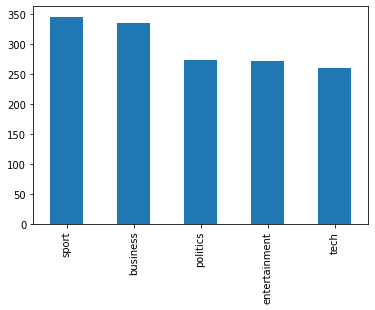

In [6]:
print(train['Category'].value_counts())
train['Category'].value_counts().plot.bar(ylim=0)

In [6]:
our_special_word = 'qwerty'

def remove_ascii_words(df):
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'Text'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'Text'] = df.loc[i, 'Text'].replace(word, our_special_word)
    return non_ascii_words

non_ascii_words = remove_ascii_words(train)

print('Replaced {} words with characters with an ordinal >= 128 in the train data.'.format(len(non_ascii_words)))
print('top 5 non_ascii_words:', np.array(non_ascii_words[:5]).T)

Replaced 924 words with characters with an ordinal >= 128 in the train data.
top 5 non_ascii_words: ['(£5.7bn)' '(£89m)' '(£378.8m)' '(£23.2m)' '(£9.9m)']


In [7]:
def clean(text):
    stop = stopwords.words('english')
    stop.append(our_special_word)
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    
    stop_free = ' '.join([word for word in text.split() if word not in (stop)])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word, 'v') for word in punc_free.split()])
    return normalized.lower()

In [8]:
train['clean_text'] = train['Text'].apply(clean)

In [9]:
train['tokenized_text'] = list(map(nltk.word_tokenize, train.clean_text))

In [11]:
train.head()

ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

                                          clean_text  \
0  worldcom exboss launch defence lawyers defend ...   
1  german business confidence slide german busine...   
2  bbc poll indicate economic gloom citizens majo...   
3  lifestyle govern mobile choice faster better f...   
4  enron boss 168m payout eighteen former enron d...   

                                      tokenized_text  
0  [worldcom, exboss, launch, defence, lawyers, d...  
1  [german, business, confidence, slide, german, ...  
2  [bbc, poll, indicate, economic, gloom, citizen...  
3  [lifestyle, govern, mobile, choice, faster, be...  
4  [enron, boss, 168m, payout, eighteen, former, ...

In [12]:
tokenized_only_dict = Counter(np.concatenate(train.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [13]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

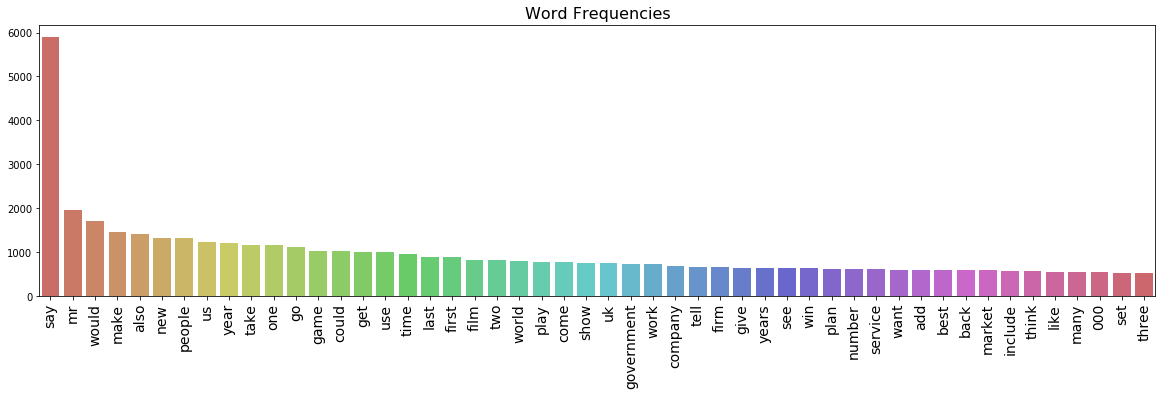

In [14]:
def word_frequency_barplot(df, nr_top_words=50):
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

In [14]:
dictionary = corpora.Dictionary(documents=train.tokenized_text.values)
print("Found {} words.".format(len(dictionary.values())))

Found 22642 words.


In [15]:
dictionary.filter_extremes(no_above=0.8, no_below=3)
dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 8842 words.


In [16]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in train['tokenized_text']]

In [18]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [19]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

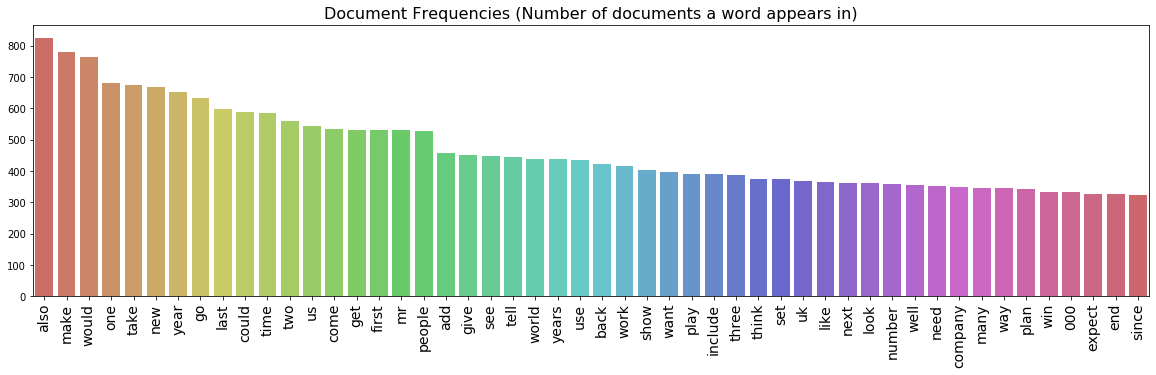

In [20]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [121]:
def multi_LDA_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_scores = []
    perplexity_scores = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model = LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=num_topics,workers=4,chunksize=4000, passes=7, alpha='asymmetric')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())
        perplexity_scores.append(np.exp2(-model.log_perplexity(corpus)))

    return model_list, coherence_scores, perplexity_scores

In [126]:
model_list, coherence_scores, perplexity_scores = multi_LDA_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=train.tokenized_text, start=5, limit=50, step=5)

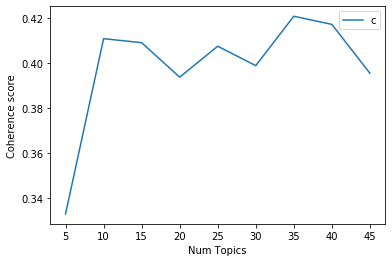

In [128]:
limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_scores"), loc='best')
plt.show()# Print the coherence scores

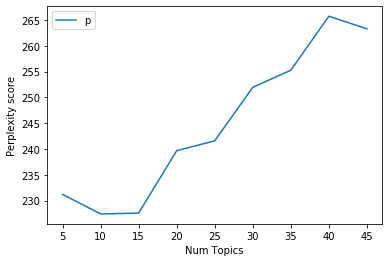

In [129]:
limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, perplexity_scores)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_scores"), loc='best')
plt.show()

In [134]:
co_mean = np.mean(coherence_scores)
co_std = np.std(coherence_scores)
per_mean = np.mean(perplexity_scores)
per_std = np.std(perplexity_scores)

stan = []

for i in range(len(coherence_scores)):
    co_standard = (coherence_scores[i] - co_mean) / co_std
    per_standard = (perplexity_scores[i] - per_mean) / per_std
    print("Topic ", (i+1)*5, ";  Coherence : ", co_standard, "  Perplexity : ", per_standard, "  co-per : ", co_standard - per_standard)
    stan.append(co_standard - per_standard)

print("Best number of topics found: ", (stan.index(max(stan))+1)*5)

Topic  5 ;  Coherence :  -2.6462025295177716   Perplexity :  -0.975771443852135   co-per :  -1.6704310856656366
Topic  10 ;  Coherence :  0.4990265669880121   Perplexity :  -1.246488826799055   co-per :  1.745515393787067
Topic  15 ;  Coherence :  0.4266649813264597   Perplexity :  -1.2354176089521325   co-per :  1.662082590278592
Topic  20 ;  Coherence :  -0.19222204787114255   Perplexity :  -0.3707937317184606   co-per :  0.17857168384731803
Topic  25 ;  Coherence :  0.3634111062225161   Perplexity :  -0.23358816223834855   co-per :  0.5969992684608647
Topic  30 ;  Coherence :  0.014665663353051283   Perplexity :  0.5071854518298684   co-per :  -0.4925197884768171
Topic  35 ;  Coherence :  0.9011722642987103   Perplexity :  0.7444606758432759   co-per :  0.15671158845543443
Topic  40 ;  Coherence :  0.7552321265652144   Perplexity :  1.4922596620140023   co-per :  -0.7370275354487879
Topic  45 ;  Coherence :  -0.12174813136506113   Perplexity :  1.318153983872977   co-per :  -1.43990

### Using GridSearchCV to find best LDA Model

In [10]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(train['clean_text'])

In [12]:
lda_CV = GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(learning_decay=0.7,n_components=None, topic_word_prior=0.1, n_jobs=1), n_jobs=2,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'doc_topic_prior': [0.5, 2, 5], 'topic_word_prior':[0.1, 0.5, 2, 3.5]}, 
       pre_dispatch='2*n_jobs', return_train_score='warn', verbose=0)

lda_CV.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=None, n_jobs=1,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=0.1,
                                                 to

In [13]:
best_lda_model = lda_CV.best_estimator_
print("Best Model's Params: ", lda_CV.best_params_)
print("Best Log Likelihood Score: ", lda_CV.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'doc_topic_prior': 0.5, 'n_components': 10, 'topic_word_prior': 0.5}
Best Log Likelihood Score:  -462104.86509931536
Model Perplexity:  2224.949648141915


### Classification

In [17]:
%%time
num_topics = 10
LDAmodel = LdaMulticore(corpus=doc_term_matrix,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='symmetric')

Wall time: 23.4 s


In [66]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model")
LDAmodel.save(temp_file)

#lda = LdaModel.load(temp_file)

In [18]:
label_encoder = LabelEncoder()

label_encoder.fit(train.Category)
train['category_id'] = label_encoder.transform(train.Category)

In [19]:
def document_to_lda_features(lda_model, document):
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

In [29]:
train['lda_features'] = list(map(lambda doc: document_to_lda_features(LDAmodel, doc), doc_term_matrix))
X_train_lda = np.array(list(map(np.array, train.lda_features)))

In [176]:
lr = LogisticRegression(multi_class='multinomial')
param_grid = {'penalty': ['l1', 'l2']}
grid_cv = GridSearchCV(lr, param_grid=param_grid, cv=5, n_jobs=-1)
best_model = grid_cv.fit(X_train_lda, train.category_id)

print('Best Score:', best_model.best_score_)
print('Best Params:', best_model.best_params_)

Best Score: 0.8134228187919463
Best Params: {'penalty': 'l2'}


In [30]:
rfc = RandomForestClassifier()
rfc.fit(X_train_lda, train.category_id)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Making Predictions

In [31]:
non_ascii_words = remove_ascii_words(test)

print('Replaced {} words with characters with an ordinal >= 128 in the train data.'.format(len(non_ascii_words)))
print('top 5 non_ascii_words:', np.array(non_ascii_words[:5]).T)

Replaced 478 words with characters with an ordinal >= 128 in the train data.
top 5 non_ascii_words: ['(£9.1bn;' '£35bn' '£4bn' '£50bn' '£8bn']


In [32]:
test['clean_text'] = test['Text'].apply(clean)
test['tokenized_text'] = list(map(nltk.word_tokenize, test.clean_text))

In [171]:
test.head()

ArticleId                                               Text  \
0       1018  qpr keeper day heads for preston queens park r...   
1       1319  software watching while you work software that...   
2       1138  d arcy injury adds to ireland woe gordon d arc...   
3        459  india s reliance family feud heats up the ongo...   
4       1020  boro suffer morrison injury blow middlesbrough...   

                                          clean_text  \
0  qpr keeper day head preston queen park rangers...   
1  software watch work software monitor every key...   
2  arcy injury add ireland woe gordon arcy rule i...   
3  india reliance family feud heat ongoing public...   
4  boro suffer morrison injury blow middlesbrough...   

                                      tokenized_text  \
0  [qpr, keeper, day, head, preston, queen, park,...   
1  [software, watch, work, software, monitor, eve...   
2  [arcy, injury, add, ireland, woe, gordon, arcy...   
3  [india, reliance, family, feud, heat, ongoing,...   
4  [boro, suffer, morrison, injury, blow, middles...   

                                        lda_features  
0  [0.002853119047358632, 0.0020755690056830645, ...  
1  [0.2948298752307892, 0.00072978570824489, 0.00...  
2  [0.0016041615745052695, 0.001185800414532423, ...  
3  [0.30077189207077026, 0.0011142214061692357, 0...  
4  [0.18789291381835938, 0.0024333116598427296, 0...

In [33]:
test_doc_term_matrix = [dictionary.doc2bow(rev) for rev in test['tokenized_text']]

In [34]:
test['lda_features'] = list(map(lambda doc: document_to_lda_features(LDAmodel, doc), test_doc_term_matrix))
X_test_lda = np.array(list(map(np.array, test.lda_features)))

In [35]:
predictions = rfc.predict(X_test_lda)

In [164]:
predictions = best_model.predict(X_test_lda)

In [36]:
predicted_labels = label_encoder.inverse_transform(predictions)

In [37]:
test_labels = pd.read_csv('datasets/BBC News Split Dataset/BBC News Test Labels.csv')

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(test_labels.Category,predicted_labels)
print('Confusion matrix : \n',matrix)

matrix = classification_report(test_labels.Category,predicted_labels)
print('Classification report : \n',matrix)

Confusion matrix : 
 [[39 25 22 36 25]
 [45 26 29 26 21]
 [39 33 16 36 23]
 [45 21 23 34 24]
 [36 25 34 31 21]]
Classification report : 
                precision    recall  f1-score   support

     business       0.19      0.27      0.22       147
entertainment       0.20      0.18      0.19       147
     politics       0.13      0.11      0.12       147
        sport       0.21      0.23      0.22       147
         tech       0.18      0.14      0.16       147

     accuracy                           0.19       735
    macro avg       0.18      0.19      0.18       735
 weighted avg       0.18      0.19      0.18       735

